# Imports

In [1]:
import sys
 
# setting path
sys.path.append('..')

In [2]:
from model_builder import ModelBuilder
import matplotlib.pyplot as plt

# Model

In [3]:
model_builder = ModelBuilder()

# Create Dataset

In [5]:
response_variable=['Response_Variable_Brazil_Atlantic_Forest_0forest_1deforested']
# feature_names=['brazil_roads','elevation','slope','brazil_protected_areas','population_density','forest_age','urbanization',
#                'brazil_surrounding_forest','brazil_pasture','brazil_agriculture','south_america_rivers','urban_distance']

feature_names = ['elevation', 'slope', 'south_america_rivers', 'brazil_roads', 'urban_distance', 'brazil_protected_areas', 
                 'brazil_surrounding_forest', 'brazil_pasture', 'brazil_agriculture', 'population_density', 'forest_age', 'urbanization']

# feature_names = ['elevation', 'slope', 'distRivers', 'distRoads', 'distUrban', 'distPA', 
#                'forest', 'pasture', 'agriculture', 'populationDensity', 'forestAge', 'urbanization']
# response_variable=['response']


gcp_bucket = 'eartshot-science-team'
gcp_folder_name = 'deforestation_risk'
samples_folder_name = f'Brazil_Atlantic_Forest_10km2_grids_samples_csv_scale30_1000numPoints'
name_csv_samples_merged_file = 'Brazil_Atlantic_Forest_10km2_grids_samples_csv_scale30_1000numPoints_val_test_set_10km_buffer.csv'
name_csv_samples_merged_file = '/Users/margauxmforstyhe/Desktop/workspace/Earthshot Labs/workspace/Science/science/Global_UNR_model/Mature_Forest_Biomass/temp/Brazil_Atlantic_Forest_10km2_grids_samples_csv_scale30_1000numPoints_val_test_set_10km_buffer.csv'

# samples_folder_name = f'deforestationRisk_MA_samples'
# name_csv_samples_merged_file = '/Users/margauxmforstyhe/Desktop/deforestationRisk_MA_renamed2.csv'

In [31]:
model_builder.create_dataset(response_variable=response_variable, 
                             samples_csv_local=True,
                             feature_names=feature_names, 
                             gcp_bucket=gcp_bucket, 
                             gcp_folder_name=gcp_folder_name, 
                             samples_folder_name= samples_folder_name, 
                             name_csv_samples_merged_file = name_csv_samples_merged_file, 
                             use_test_val_buffered_sets = False,
                             # name_test_buffer_column='test_set_5km_buffer', 
                             # name_val_buffer_column='val_set_5km_buffer', 
                             # name_test_no_buffer_column='test_set_no_buffer', 
                             # name_val_no_buffer_column='val_set_no_buffer'
                            )

Reading sample csv file: /Users/margauxmforstyhe/Desktop/workspace/Earthshot Labs/workspace/Science/science/Global_UNR_model/Mature_Forest_Biomass/temp/Brazil_Atlantic_Forest_10km2_grids_samples_csv_scale30_1000numPoints_val_test_set_10km_buffer.csv...
We have 4016577 samples
Training samples: 3213261
Test samples: 803316
Validation samples: 0


In [32]:
model_builder.X_train.head()

,elevation,slope,south_america_rivers,brazil_roads,urban_distance,brazil_protected_areas,brazil_surrounding_forest,brazil_pasture,brazil_agriculture,population_density,forest_age,urbanization
3040023,5,0,1272.193359,872.241178,1446.159479,100130.978329,176,407,0,1.400193,15,0
1101708,4,1,2140.213113,1109.880922,708.225931,203.723764,754,0,0,649.664250,14,7
162259,238,7,1140.512735,118.579017,2682.740461,55742.310161,131,830,0,50.877464,31,1
2382080,225,2,2697.774084,910.056474,3079.172133,81181.961433,70,891,0,7.423456,50,1
1262778,48,6,946.434435,91.251456,2713.023602,40004.852165,688,176,25,67.748535,13,1


In [49]:
model_builder.y_train.head(2)

,Response_Variable_Brazil_Atlantic_Forest_0forest_1deforested
3040023,0
1101708,0


In [35]:
nb_forest_samples = model_builder.y_train[model_builder.y_train[response_variable[0]] == 0][response_variable[0]].count()
nb_deforested_samples = model_builder.y_train[model_builder.y_train[response_variable[0]] == 1][response_variable[0]].count()
print(f'There are {nb_forest_samples} forest samples and {nb_deforested_samples} deforested samples in training set')

# nb_forest_samples = model_builder.y_val[model_builder.y_val[response_variable[0]] == 0][response_variable[0]].count()
# nb_deforested_samples = model_builder.y_val[model_builder.y_val[response_variable[0]] == 1][response_variable[0]].count()
# print(f'There are {nb_forest_samples} forest samples and {nb_deforested_samples} deforested samples in validation set')

nb_forest_samples_test = model_builder.y_test[model_builder.y_test[response_variable[0]] == 0][response_variable[0]].count()
nb_deforested_samples_test = model_builder.y_test[model_builder.y_test[response_variable[0]] == 1][response_variable[0]].count()
print(f'There are {nb_forest_samples_test} forest samples and {nb_deforested_samples_test} deforested samples in test set')


There are 2908831 forest samples and 304430 deforested samples in training set
There are 727756 forest samples and 75560 deforested samples in test set


In [36]:
# Training Predictors samples 
model_builder.X_train.shape

(3213261, 12)

In [37]:
# Training Response samples 
model_builder.y_train.shape

(3213261, 1)

In [38]:
# Test Predictors samples 
model_builder.X_test.shape

(803316, 12)

In [39]:
# Test Response samples 
model_builder.y_test.shape

(803316, 1)

In [40]:
model_builder.feature_names

['elevation',
 'slope',
 'south_america_rivers',
 'brazil_roads',
 'urban_distance',
 'brazil_protected_areas',
 'brazil_surrounding_forest',
 'brazil_pasture',
 'brazil_agriculture',
 'population_density',
 'forest_age',
 'urbanization']

In [41]:
model_builder.response_variable

['Response_Variable_Brazil_Atlantic_Forest_0forest_1deforested']

# Hyperparameters tuning

Finding best hyperparameters with GridSearch

In [9]:
# Uses val set 
best_params = model_builder.grid_search(n_estimators=[100, 200, 500], 
                                        max_features=['sqrt', 'log2'], 
                                        max_depth=[4,5,6,7,8], 
                                        criterion=['squared_error', 'absolute_error'], 
                                        random_state=42)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}


In [10]:
best_params

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}

# Training

In [42]:
model_builder.initialize_model(nb_trees=100, max_depth=5, random_state=42, max_features='sqrt', n_cores=-1, 
                               oob_score=True, bootstrap=True, criterion='squared_error')

In [43]:
model_builder.model

RandomForestRegressor(max_depth=5, max_features='sqrt', n_jobs=-1,
                      oob_score=True, random_state=42, verbose=1)

In [44]:
model_builder.train()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


# Evaluation

In [45]:
# # On validation set
# y_pred_val, mae_val, mse_val, rmse_val, oob_score_val, r2_val, feature_imp_val = model_builder.evaluate(X_test=model_builder.X_val,
#                                                                     y_test=model_builder.y_val,
#                                                                     save_figures=False, saving_base_output_name='testing_val_set')


Evaluation...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished





Mean Absolute Error (MAE): 0.16821783831141845
Mean Squared Error (MSE): 0.08330914435440898
Root Mean Squared Error (RMSE): 0.28863323501358773
OOB prediction of accuracy is: 2.207970055834918%

R2: 0.022340185943171553


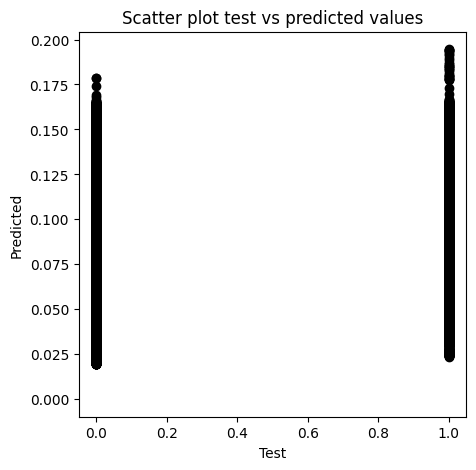

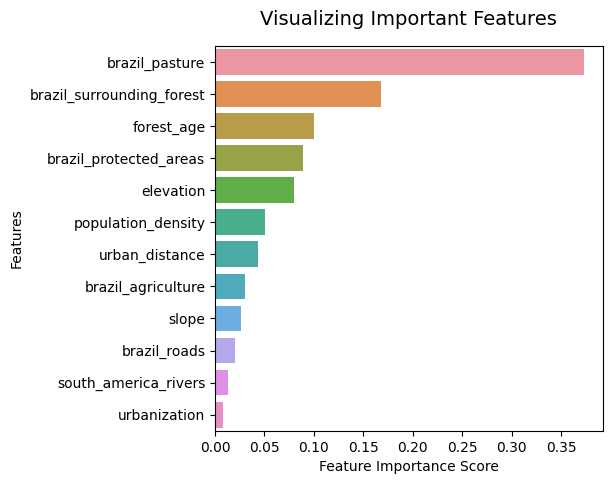

In [46]:
# On test set
y_pred_test, mae_test, mse_test, rmse_test, oob_score_test, r2_test, feature_imp_test = model_builder.evaluate(X_test=model_builder.X_test,
                                                                    y_test=model_builder.y_test,
                                                                    save_figures=False, saving_base_output_name='testing_test_set')

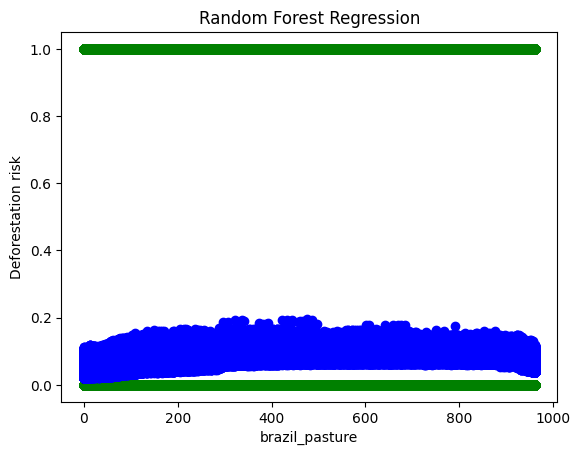

In [47]:
predictor = 'brazil_pasture'
plt.scatter(model_builder.X_test[predictor].values, model_builder.y_test, color = 'green')
plt.scatter(model_builder.X_test[predictor].values, y_pred_test, color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel(predictor)
plt.ylabel('Deforestation risk')
plt.show()

# Inference on tiles

In [ ]:
model_builder.inference(mask_band='forest_age', 
                        tiles_folder_name='Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster', 
                        tiles_in_GCP=False,   # Running locally
                        RF_output_folder_temp='TEST_RF_outputs_temp',
                        path_to_tiles_local='/Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster'
                       )


There are 58 inference tiles

Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_52.tif
Image opened
tile shape: (7422, 6857, 12)
Reshaped from (7422, 6857, 12) to (50892654, 12)
(50892654, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   19.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   41.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 6857)
[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 86 91 93]
(7422, 6857)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_12_23_0.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_46.tif
Image opened
tile shape: (2665, 3127, 12)
Reshaped from (2665, 3127, 12) to (8333455, 12)
(8333455, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2665, 3127)
[ 0 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49]
(2665, 3127)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_12_32_1.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_8.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   35.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_14_36_2.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_9.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   44.1s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_17_02_3.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_47.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   25.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.0min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72 73 78 81]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_20_00_4.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_53.tif
Image opened
tile shape: (7422, 7423, 12)
Reshaped from (7422, 7423, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   19.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   51.2s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7423)
[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81]
(7422, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_23_03_5.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_45.tif
Image opened
tile shape: (4900, 7422, 12)
Reshaped from (4900, 7422, 12) to (36367800, 12)
(36367800, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   10.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   23.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (4900, 7422)
[ 0  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48]
(4900, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_24_31_6.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_51.tif
Image opened
tile shape: (4242, 4779, 12)
Reshaped from (4242, 4779, 12) to (20272518, 12)
(20272518, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   10.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (4242, 4779)
[ 0 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 65]
(4242, 4779)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_25_20_7.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_50.tif
Image opened
tile shape: (1534, 511, 12)
Reshaped from (1534, 511, 12) to (783874, 12)
(783874, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1534, 511)
[0]
(1534, 511)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_25_21_8.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_44.tif
Image opened
tile shape: (7423, 7422, 12)
Reshaped from (7423, 7422, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   42.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 7422)
[  0   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  93  97  99 101]
(7423, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_27_47_9.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_40.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   56.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[  0   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  68 255]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_30_31_10.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_54.tif
Image opened
tile shape: (7422, 7423, 12)
Reshaped from (7422, 7423, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   48.1s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7423)
[ 0 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 69]
(7422, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_33_13_11.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_55.tif
Image opened
tile shape: (7423, 7423, 12)
Reshaped from (7423, 7423, 12) to (55100929, 12)
(55100929, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   48.3s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 7423)
[ 0 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 46]
(7423, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_35_38_12.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_41.tif
Image opened
tile shape: (7422, 7053, 12)
Reshaped from (7422, 7053, 12) to (52347366, 12)
(52347366, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   36.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7053)
[  0   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55 255]
(7422, 7053)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_38_12_13.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_57.tif
Image opened
tile shape: (3623, 7423, 12)
Reshaped from (3623, 7423, 12) to (26893529, 12)
(26893529, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   14.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3623, 7423)
[ 0  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
(3623, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_39_16_14.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_43.tif
Image opened
tile shape: (5105, 7422, 12)
Reshaped from (5105, 7422, 12) to (37889310, 12)
(37889310, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   21.9s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (5105, 7422)
[ 0  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 83 84 85 88 94 98]
(5105, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_40_59_15.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_42.tif
Image opened
tile shape: (7275, 3792, 12)
Reshaped from (7275, 3792, 12) to (27586800, 12)
(27586800, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   14.2s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7275, 3792)
[  0  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  50 255]
(7275, 3792)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_42_12_16.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_56.tif
Image opened
tile shape: (7422, 7423, 12)
Reshaped from (7422, 7423, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   16.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   34.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7423)
[ 0  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 44 45 46]
(7422, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_44_35_17.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_19.tif
Image opened
tile shape: (7422, 4847, 12)
Reshaped from (7422, 4847, 12) to (35974434, 12)
(35974434, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   11.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   23.3s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 4847)
[ 0  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77]
(7422, 4847)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_46_03_18.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_31.tif
Image opened
tile shape: (1397, 1263, 12)
Reshaped from (1397, 1263, 12) to (1764411, 12)
(1764411, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1397, 1263)
[ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 35 37 38 40 41 46 48
 50 56 60]
(1397, 1263)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_46_06_19.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_25.tif
Image opened
tile shape: (4598, 1476, 12)
Reshaped from (4598, 1476, 12) to (6786648, 12)
(6786648, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    3.1s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (4598, 1476)
[  0  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28
  29  30  31  32  33  34  35  36  37  38  39  40  41  42  44  46  52 255]
(4598, 1476)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_46_12_20.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_24.tif
Image opened
tile shape: (2569, 3280, 12)
Reshaped from (2569, 3280, 12) to (8426320, 12)
(8426320, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    4.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2569, 3280)
[ 0 47 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 78 80 81 85]
(2569, 3280)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_46_20_21.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_30.tif
Image opened
tile shape: (219, 118, 12)
Reshaped from (219, 118, 12) to (25842, 12)
(25842, 12)
Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (219, 118)
[0]
(219, 118)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_46_20_22.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_18.tif
Image opened


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


tile shape: (5161, 3859, 12)
Reshaped from (5161, 3859, 12) to (19916299, 12)
(19916299, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   10.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (5161, 3859)
[ 0  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 50 51 54]
(5161, 3859)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_47_08_23.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_26.tif
Image opened
tile shape: (7422, 3763, 12)
Reshaped from (7422, 3763, 12) to (27928986, 12)
(27928986, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   15.6s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 3763)
[  0  15  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32
  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80 255]
(7422, 3763)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_48_12_24.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_32.tif
Image opened
tile shape: (7423, 6134, 12)
Reshaped from (7423, 6134, 12) to (45532682, 12)
(45532682, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   16.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   35.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 6134)
[ 0  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 59 60]
(7423, 6134)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_50_12_25.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_33.tif
Image opened
tile shape: (7422, 7423, 12)
Reshaped from (7422, 7423, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   19.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   51.2s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7423)
[  0   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  73 255]
(7422, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_52_51_26.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_27.tif
Image opened
tile shape: (7423, 4626, 12)
Reshaped from (7423, 4626, 12) to (34338798, 12)
(34338798, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   21.1s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 4626)
[  0  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85 255]
(7423, 4626)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_54_29_27.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_23.tif
Image opened
tile shape: (7423, 7422, 12)
Reshaped from (7423, 7422, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.2min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 7422)
[ 0  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80 81 82 83 84 85 86 87 88 89 90 91 94]
(7423, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_57_48_28.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_37.tif
Image opened
tile shape: (3812, 2431, 12)
Reshaped from (3812, 2431, 12) to (9266972, 12)
(9266972, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    5.9s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3812, 2431)
[0]
(3812, 2431)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_58_01_29.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_36.tif
Image opened
tile shape: (7422, 4975, 12)
Reshaped from (7422, 4975, 12) to (36924450, 12)
(36924450, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   10.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   23.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 4975)
[  0  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80 255]
(7422, 4975)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-12_59_41_30.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_22.tif
Image opened
tile shape: (7422, 5007, 12)
Reshaped from (7422, 5007, 12) to (37161954, 12)
(37161954, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   13.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   27.5s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 5007)
[  0   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  46  53 255]
(7422, 5007)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_01_27_31.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_34.tif
Image opened
tile shape: (7422, 7423, 12)
Reshaped from (7422, 7423, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   26.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.5min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7423)
[  0   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64 255]
(7422, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_04_52_32.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_20.tif
Image opened
tile shape: (6142, 4160, 12)
Reshaped from (6142, 4160, 12) to (25550720, 12)
(25550720, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   14.1s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (6142, 4160)
[ 0  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 44]
(6142, 4160)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_05_59_33.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_21.tif
Image opened
tile shape: (7, 5, 12)
Reshaped from (7, 5, 12) to (35, 12)
(35, 12)
Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7, 5)
[0]
(7, 5)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_06_00_34.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_35.tif
Image opened


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


tile shape: (7423, 7423, 12)
Reshaped from (7423, 7423, 12) to (55100929, 12)
(55100929, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   37.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.1min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 7423)
[  0  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74 255]
(7423, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_09_26_35.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_38.tif
Image opened
tile shape: (2203, 7422, 12)
Reshaped from (2203, 7422, 12) to (16350666, 12)
(16350666, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    8.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2203, 7422)
[  0   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  54 255]
(2203, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_10_05_36.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_10.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   18.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   45.8s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_12_07_37.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_11.tif
Image opened
tile shape: (7423, 7422, 12)
Reshaped from (7423, 7422, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.1min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 7422)
[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63]
(7423, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_15_07_38.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_39.tif
Image opened
tile shape: (7423, 7422, 12)
Reshaped from (7423, 7422, 12) to (55093506, 12)
(55093506, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   26.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.2min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 7422)
[ 0  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78
 79 80 81 82 85 88 89]
(7423, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_18_27_39.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_13.tif
Image opened
tile shape: (3422, 4266, 12)
Reshaped from (3422, 4266, 12) to (14598252, 12)
(14598252, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    9.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3422, 4266)
[ 0 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 59]
(3422, 4266)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_19_08_40.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_12.tif
Image opened
tile shape: (1527, 905, 12)
Reshaped from (1527, 905, 12) to (1381935, 12)
(1381935, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1527, 905)
[ 0 17]
(1527, 905)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_19_10_41.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_16.tif
Image opened
tile shape: (7422, 6758, 12)
Reshaped from (7422, 6758, 12) to (50157876, 12)
(50157876, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   22.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   50.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 6758)
[ 0 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
(7422, 6758)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_21_28_42.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_17.tif
Image opened
tile shape: (4569, 6648, 12)
Reshaped from (4569, 6648, 12) to (30374712, 12)
(30374712, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    7.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   24.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (4569, 6648)
[ 0 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 53 54 55 56 57 58]
(4569, 6648)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_22_45_43.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_15.tif
Image opened
tile shape: (3831, 2804, 12)
Reshaped from (3831, 2804, 12) to (10742124, 12)
(10742124, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.1s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (3831, 2804)
[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60]
(3831, 2804)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_22_58_44.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_29.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   25.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.3min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[  0   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  81  82  83  84 255]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_26_16_45.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_28.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   20.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   57.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[  0   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86 255]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_29_22_46.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_14.tif
Image opened
tile shape: (6375, 5525, 12)
Reshaped from (6375, 5525, 12) to (35221875, 12)
(35221875, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   14.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   27.6s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (6375, 5525)
[ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
(6375, 5525)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-13_31_01_47.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_1.tif
Image opened
